# 15. An end-to-end `gemlib` tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/15_end_to_end.ipynb)

In this notebook example, we will use `gemlib` to implement a simple stochastic metapopulation SIR model, and simulate from it.  The notebook falls into two parts, firstly simulating from an epidemic model, and secondly embedding an epidemic model in a Bayesian hierarchy and using MCMC to draw samples from the posterior conditional on observing part of the epidemic timeseries.

## Install `gemlib`

We'll start by installing the `gemlib` library.

In [1]:
from warnings import warn

try:
    import google.colab
    !pip install -Uq gemlib
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

/tmp/ipykernel_59200/1793800732.py:7: UserWarning: Not running in Colab, make sure `gemlib` is installed locally
  warn("Not running in Colab, make sure `gemlib` is installed locally")


and now import the modules we need for this notebook...

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import NamedTuple

import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
from gemlib.distributions import DiscreteTimeStateTransitionModel

tfd = tfp.distributions

%matplotlib inline

DTYPE=np.float32

2024-11-22 09:01:54.733555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 09:01:54.742101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 09:01:54.754208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 09:01:54.754232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 09:01:54.762728: I tensorflow/core/platform/cpu_feature_gua

# A simple two-metapopulation epidemic model

We're going to model our epidemic using a SIR model, where individuals begin as susceptible, become infected and recover from their infection.

Here, we have 3 _states_: $S$, $I$, and $R$ representing susceptible, infected, and recovered individuals respectively.

We then have two transitions, $S \rightarrow I$ and $I \rightarrow R$.

## Implementing the SIR model in `gemlib`

Having specified our _states_, the _transitions_ between states, and the rates at which they occur, we can start to assemble a model for the disease process.  We'll do this using `gemlib`'s `DiscreteTimeStateTransitionModel`, which embeds the above model into a discrete-time state transition stochastic process.

There are 3 key ingredients to implementing a model:

* The _incidence matrix_ which describes the state transition graph
* The _initial state_ matrix describing the global state of the epidemic at the beginning
* The _transition rate function_ which, given the time and a global state, computes the transition rates for each individual along each transition.

### Incidence matrix

Not to be confused with epidemic case incidence, the _incidence matrix_ encodes the SIR state transition graph numerically.  Each column represents a transition and gives the increment in each state that occurs should an individual undergo that transition.  

Notice that we explicitly enumerate states `S, I, R` and transitions `SI` and `IR` in order.  The order doesn't matter, as long as we are consistent throughout.

In [3]:
incidence_matrix = np.array(
    [ #   SI  IR
        [-1,  0],  # S
        [ 1, -1],  # I
        [ 0,  1],  # R
    ],
    dtype=DTYPE
    )

### Initial state

The initial state (or initial conditions) matrix describes the global state of the population at the start of the epidemic.

We represent this as a `[2, M]` for our 2 populations and $M$ states.

We'll start with a population size of 100 for each metapopulation, with one initial infected individual in the first population and the remaining susceptible.

In [4]:
initial_state = np.array([[999, 1, 0],
                          [1000, 0, 0]],
                          dtype=np.float32)

We can specity a connectivity matrix to define non-homogeneous mixing between populations.

In [5]:
connectivity = np.array(
    [
        [0.0 , 1.0],
        [1.0 , 0.0],
    ],
    dtype=np.float32
)

### Transition rate function

Now we need to express our transition rates, which we do by creating a function that returns a tuple of three arrays giving the transition rates between each state.  Strict ordering of states and transition rates is maintained as for the incidence matrix above.

In [6]:
def transition_rates(t, state):
    beta1 = DTYPE(0.5)
    beta2 = DTYPE(0.2)
    gamma = DTYPE(0.14)

    within = beta1 * state[:,1] # within population transmission rate

    between = beta2 * tf.linalg.matvec(connectivity, # between population transmission
                                       state[:, 1]/tf.reduce_sum(state, axis=-1))

    si_rate = (within + between) / tf.reduce_sum(state, axis=-1)
    ir_rate = gamma

    return si_rate, ir_rate

### The discrete-time model

With the data structures and functions above, we can now instantiate the `DiscreteTimeStateTransitionModel`

In [7]:
sir = DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                       incidence_matrix=incidence_matrix,
                                       initial_state=initial_state,
                                       initial_step=0,
                                       time_delta=1.0,
                                       num_steps=110)

2024-11-22 09:02:00.772377: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-11-22 09:02:00.772400: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: emerald
2024-11-22 09:02:00.772403: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: emerald
2024-11-22 09:02:00.772551: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 565.57.1
2024-11-22 09:02:00.772564: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  565.57.01  Release Build  (dvs-builder@U16-A24-9-2)  Thu Oct 10 12:15:00 UTC 2024
GCC version:  gcc version 14.2.0 (Ubuntu 14.2.0-4ubuntu2) 
"


and run a simulation using the `sample` method.

In [8]:
sir_sim = sir.sample(seed=[0, 6])

sample() spits out a tensor of dimension [T, N, L] for  𝑇  timesteps, 𝑁  metapopulations or individuals (in this case N = 2),   and 𝐿  transitions. This tensor,  𝑍 , is such that $z^{qr}_{it}=1$  if individual  𝑖  undergoes a transition from  𝑞  to  𝑟  at timestep  𝑡 .

We can therefore compute the total number of each type of transition happening on each day by taking the sum across the first dimension (i.e.  𝑁 ) of the tensor.

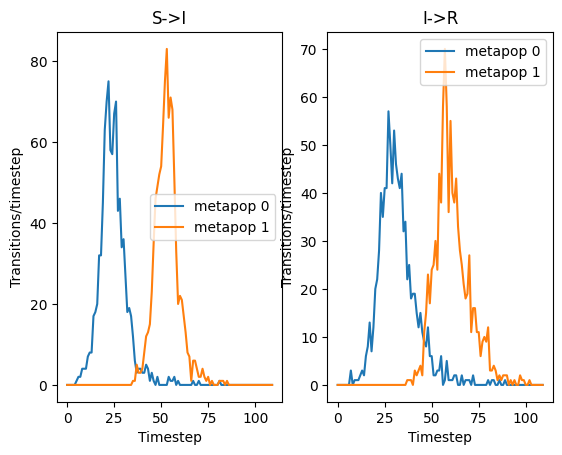

In [9]:
def plot_timeseries(events, title, ylabel, ax):
    ax.plot(
        events, label=[f"metapop {i}" for i in range(sir_sim.shape[1])]
    )
    ax.set_title(title)
    ax.set_xlabel("Timestep")
    ax.set_ylabel(ylabel)
    ax.legend()

fig, ax = plt.subplots(1, 2)
plot_timeseries(sir_sim[...,0], "S->I", "Transitions/timestep", ax[0])
plot_timeseries(sir_sim[...,1], "I->R", "Transitions/timestep", ax[1])

We can also plot an epicurve, plotting the number of individuals in each state per day.

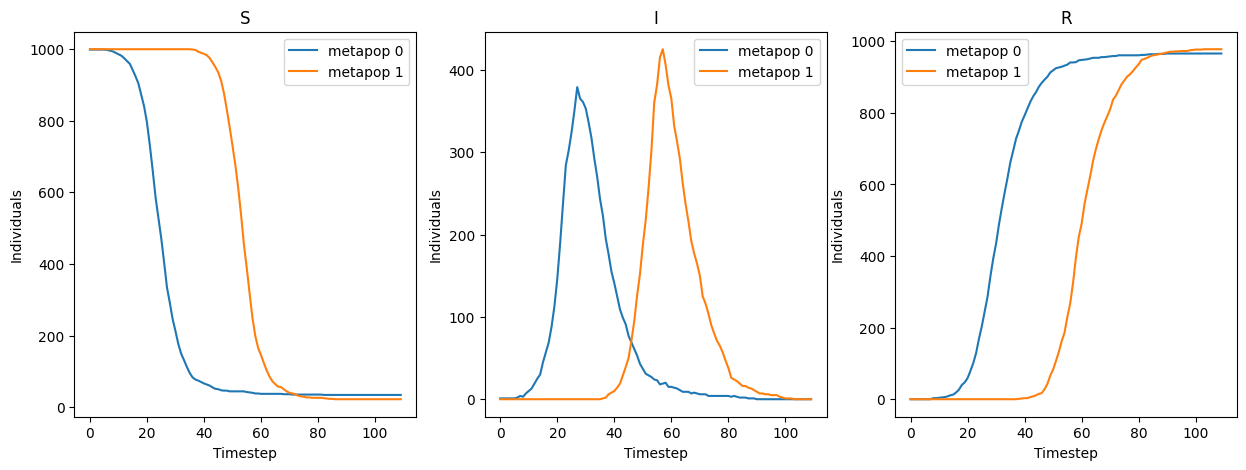

In [10]:
sir_sim_state = sir.compute_state(sir_sim)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plot_timeseries(sir_sim_state[...,0], "S", "Individuals", ax[0])
plot_timeseries(sir_sim_state[...,1], "I", "Individuals", ax[1])
plot_timeseries(sir_sim_state[...,2], "R", "Individuals", ax[2])


### Using Tensorflow for performance

You may have noticed that the simulation we have run above is not exactly snappy!  Since we're using Tensorflow, we can use the power of either Graph Mode or XLA compilation to accerate it.  All we need to do is wrap the call to `sir.sample()` in a decorated function.

Starting with graph mode compilation:

In [11]:
@tf.function()
def run_sir_sample_graph(seed):
    return sir.sample(seed=seed)

%time sir_sim_graph = run_sir_sample_graph(seed=[0,5])

CPU times: user 265 ms, sys: 25.7 ms, total: 291 ms
Wall time: 250 ms


it's quite a bit faster! Now let's try XLA compilation:

In [12]:
@tf.function(jit_compile=True)
def run_sir_sample_xla(seed):
    return sir.sample(seed=seed)

%time sir_sim_xla = run_sir_sample_xla(seed=[0,5])

I0000 00:00:1732226523.301576   59200 service.cc:145] XLA service 0x16187a60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732226523.301619   59200 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-11-22 09:02:03.349567: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


CPU times: user 4.46 s, sys: 121 ms, total: 4.58 s
Wall time: 4.57 s


I0000 00:00:1732226527.708010   59200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


That's slower! Let's run it again...

In [13]:
%time sir_sim_xla = run_sir_sample_xla(seed=[0,5])

CPU times: user 2.61 ms, sys: 161 μs, total: 2.77 ms
Wall time: 2.11 ms


That's quicker!  When we first ran our XLA-compiled function, it took time for the compiler to build the machine code required to implement the function.  When we ran it for a second time, the compilation had already been done so all that's left is the runtime.  Try running this notebook again using a GPU runtime, and see if you get any difference in speed...

<a name="log-lik-simple"></a>
### Log-likelihood computation

The last thing in this section that we'll look at is how to compute the probability of obtaining a given timeseries of transition events given the parameters, initial state, and indeed the model.  This is, of course, cruicial for inference, as we describe in the next section.

This is super-easy to compute, just using `DiscreteTimeStateTransitionModel`'s `log_prob` method.

In [14]:
sir.log_prob(sir_sim)

<tf.Tensor: shape=(), dtype=float32, numpy=-560.7823>

### Exercises

1. See if you can create deterministic and continuous-time stochastic analogues of this model using `DeterministicStateTransitionModel` and `ContinuousTimeStateTransitionModel` methods available in the `gemlib.distributions` library, documented in the [API reference](https://gem-epidemics.gitlab.io/gemlib/api.html).

2. By embellishing `initial_state`, `incidence_matrix`, and `transition_rates`, can you implement a SVIR model with transition $S \rightarrow I$, $S \rightarrow V$, $V \rightarrow I$, $I \rightarrow R$ with a appropriate transition rates?

__N.B.__ It would be wise to create a separate notebook to perform these exercises to avoid messing up your environment for what comes below.

# Inference

Now we have a working model (and simulated data), we can use it to construct a Bayesian model by specifying prior distributions for it.

Let our epidemic model be written as
$$
\mathbf{z} \sim \mbox{SIR}(\beta_1, \beta_2, \mathbf{x}_0)
$$
where $\mathbf{z}$ is the output transition events tensor (`sir_sim` above), $\mathbf{x}_0$ is the initial state, and $\theta = \{\beta_1, \beta_2\}$ are the parameters.  We place priors on the parameters such that

\begin{align*}
\beta_1 & \sim \mbox{Gamma}(2, 4) \\
\beta_2 & \sim \mbox{Gamma}(0.5, 0.5).
\end{align*}

We will also assume that the initial state $\mathbf{x}_0$ is unknown, and place a _vector_ Multinomial distribution on it
$$
\mathbf{x}_0 \sim \mbox{VectorMultinomial}\left( \left[ \begin{array}{c} 1000 \\ 1000 \end{array} \right], 
                                                 \left[ \begin{array}{ccc} 0.99 & 0.1 & 0 \\ 0.999 & 0.01 & 0 \end{array} \right] 
                                                 \right)
$$


## Implementing a Bayesian model

To build this model, we essentially have to specify a probabilistic DAG.  In code, we do this by using the TensorFlow Probability `JointDistributionCoroutine` class.  

Notice that I've specified the entire model from scratch.  This is required because if we change the value of a parameter (as an optimiser or MCMC algorithm will), then we need to re-instantiate the model with the new parameter value.

* Think about this in terms of the Bayesian DAG, and how we write probability distributions as above, to see why this is sensible.
* It's also computing best practice -- wrapping all the logic into functions guards against unexpected results due to global variables being changed when you're not looking!

In [30]:
@tfd.JointDistributionCoroutine
def model():

    # Priors
    beta1 = yield tfd.Gamma(
        concentration=DTYPE(2.0), rate=DTYPE(4.0), name="beta1",
    )
    beta2 = yield tfd.Gamma(
        concentration=DTYPE(0.5), rate=DTYPE(0.5), name="beta2"
    )
    initial_conditions = yield tfd.Independent(
        tfd.Multinomial(
          total_count=np.array([1000, 1000], dtype=DTYPE),
          probs=np.array(
              [[0.99, 0.01, 0.0],
               [0.999, 0.001, 0.0]],
              dtype=DTYPE,
          )
        ),
        reinterpreted_batch_ndims=1,
        name="initial_conditions"
    )

    def transition_rates(t, state):
      gamma = DTYPE(0.1) # recovery rate

      within = beta1 * state[:,1] # within population transmission rate
      between = beta2 * tf.linalg.matvec(connectivity, # between population transmission
                                        state[:, 1]/tf.reduce_sum(state, axis=-1))

      si_rate = (within + between) / tf.reduce_sum(state, axis=-1)
      ir_rate = gamma

      return si_rate, ir_rate

    sir = yield DiscreteTimeStateTransitionModel(
        transition_rate_fn=transition_rates,
        incidence_matrix=incidence_matrix,
        initial_state=initial_conditions,
        initial_step=0,
        time_delta=1.0,
        num_steps=110,
        name ="sir")


## Prior simulation

So we now have an instantiated model, but what can we do with it? The first thing we might like to do is to simulate from the _prior_ model.  That is, draw the parameters from their respective prior distributions, plugging the resulting values into the SIR model and then simulating from it.  In other words, we start at the top of the DAG, and work our way downwards.

Given we've set up a `JointDistributionCoroutine`, this is very simple!  We just call the `sample()` method with a seed, and obtain a `StructTuple` of values for each of the distributions in our model.  TFP automatically takes care of drawing from the distributions in the correct order.

In [31]:
prior_sim = model.sample(seed=[0,4])


Of course, simulating from the prior distributions is not guaranteed to give us any sensible epidemic simulation output, as there is nothing constraining the parameters to be consistent with the data other than our _a priori_ belief about their values.  Even if we specified carefully chosen marginal prior distributions for the parameters, there is nothing stopping us simulating combinations of parameters that lead to non-sensical epidemic output.  

What we need to do is _condition_ the model on having observed some epidemic output, and then find a way to work out the joint _a posteriori_ distribution of the parameters in the light of these observations.  

Bayes' Theorem tells us that
$$
Pr(\theta | Z, \mathbf{x_0}) = \frac{Pr(Z | \theta, \mathbf{x}_0)Pr(\theta)}{\int_{\Theta} Pr(Z | \theta, \mathbf{x_0})Pr(\theta) \mathrm{d}\theta}
$$
where $Pr(\theta | \mathbf{z}, \mathbf{x}_0)$ is the _posterior distribution_, $Pr(\mathbf{z} | \theta, \mathbf{x}_0)$ is the probability of observing the transition event timeseries $\mathbf{z}$ given the parameters and initial state, i.e. the likelihood, $Pr(\theta)$ is the (joint) prior distribution of the parameters.

In computing, conditioning a model is essentially the same as fixing the value of a given function argument, which TFP allows us to do with the `experimental_pin` method:

In [32]:
conditioned_model = model.experimental_pin(sir=sir_sim, initial_conditions=initial_state)

The fact that we know this distribution only up to a constant is the reason we employ methods such as MCMC to draw samples from, and hence estimate, posterior distributions in all but the simplest of cases.  Readers are referred to the following texts for an in-depth discussion of these foundational principles:

* Gilks, W., Richardson, S.,, Spiegelhalter, D. (1995). Markov Chain Monte Carlo in Practice. Taylor & Francis. ISBN: 9780412055515
* Gelman, A., Carlin, J.B., Stern, H.S., Dunson, D.B., Vehtari, A., & Rubin, D.B. (2013). Bayesian Data Analysis (3rd ed.). Chapman and Hall/CRC. https://doi.org/10.1201/b16018

In [33]:
conditioned_model.log_prob(beta1=0.5, beta2=0.4)

<tf.Tensor: shape=(), dtype=float32, numpy=-666.6195>

## Simple parameter inference

In this section, we'll use TFP to build an MCMC sampler to sample from the _joint posterior distribution_ of the parameters assuming that the transition event timeseries is fully known.

Then we create an XLA-compiled function that runs the MCMC, using TFP's `sample_chain` function.  This returns a data structure of samples from the joint posterior distibution, together with a data structure containing various sampler diagnostic we might be interested in.

Finally, we run the sampler and plot some traceplots.

In [34]:
# Parameter sampling
from gemlib.mcmc import adaptive_rwmh

# Metropolis within Gibbs
from gemlib.mcmc import MwgStep

# MCMC driver
from gemlib.mcmc import mcmc

In [35]:
# Parameters
kernel = MwgStep(
    sampling_algorithm=adaptive_rwmh(initial_scale=1.0),
    target_names=["beta1", "beta2"],
)

In [36]:
num_samples = 10000

@tf.function(jit_compile=True)
def run_mcmc(initial_position, num_samples, seed=[0, 1]):
    return mcmc(
        num_samples,
        kernel,
        conditioned_model.log_prob,
        initial_position,
        seed=seed,
    )


samples, info = run_mcmc(
    conditioned_model.sample_unpinned(seed=[0, 2]), # initialise beta1 and beta2 from the prior
    num_samples=num_samples,
)

We can set a burn in period for our MCMC chain

In [37]:
burn_in = 2000

The `info` data structure contains diagnostics about our sampling, allowing us to calculate the acceptance rate of the sampler.

In [38]:
print("beta acceptance: ", np.mean(info.is_accepted[burn_in:]))

beta acceptance:  0.37025


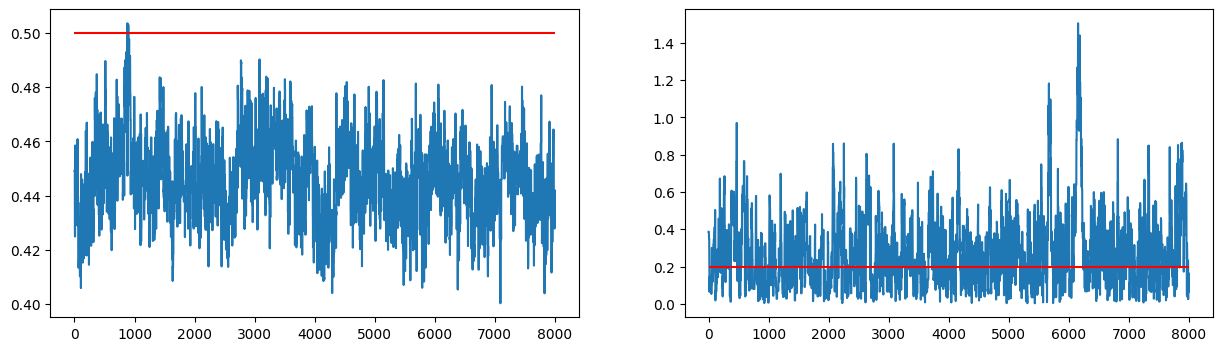

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(samples.beta1[burn_in:])
ax[0].hlines(xmin=0, xmax=samples.beta1[burn_in:].shape[0], y=0.5, color="red")
ax[1].plot(samples.beta2[burn_in:])
ax[1].hlines(xmin=0, xmax=samples.beta2[burn_in:].shape[0], y=0.2, color="red")
plt.show()

## Inference with censored transition events

In practice, of course, we can only partially observe the epidemic process.  For this example, we'll assume that we observe recovery (or removal) times, but don't observe infection ($S \rightarrow I$) transitions.

What we now need is a method for treating $S \rightarrow I$ transitions as censored data, which in a Bayesian context means treating them as parameters to be estimated.  Published methods in the literature (e.g. Roberts and O'Neill (1999) JRSS Ser A; Jewell et al. (2009) Bayesian Analysis) suggest the following Metropolis-within-Gibbs algorithm:

1. Initialise $\theta^{(0)}$, $z^{SI(0}$, $k=0$
2. For $k = 1,\dots,K$ do

    a. Draw $\theta^{k} \sim \pi(\theta | z^{(k-1)}, x_0^{(k-1)})$ <br>
    b. For $l = 1,\dots,L$ do <br>
    
    * Move events in $z \sim \pi(z | \theta^{(k)}, x_0^{(k-1)}$ <br>
    * Update initial conditions $z, x_0 \sim \pi(x_0, z | \theta^{(k)})$




`gemlib` comes with a suite of composable MCMC kernels to implement this scheme as follows.

In [40]:
# Censored events sampling functions
from gemlib.mcmc.discrete_time_state_transition_model import move_events, left_censored_events_mh
from gemlib.mcmc import multi_scan

beta_kernel = MwgStep(
    sampling_algorithm=adaptive_rwmh(initial_scale=1.0),
    target_names=["beta1", "beta2"],
)

move_kernel = MwgStep(
    move_events(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        num_units=1,
        delta_max=5,
        count_max=10,
    ),
    target_names=["sir"],
    kernel_kwargs_fn=lambda position: {"initial_conditions": position.initial_conditions}
)

left_censored_kernel = MwgStep(
    left_censored_events_mh(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        max_events=10,
        max_timepoint=14,  # Just add/del for the first 2 weeks of the epidemic
        events_varname="sir",
        initial_conditions_varname="initial_conditions",
    ),
    target_names=["initial_conditions", "sir"],
)

kernel = beta_kernel >>  multi_scan(20, move_kernel >> left_censored_kernel)

In [41]:
num_samples = 10000
initial_position = prior_sim._replace( # Convenient way to start the chain at a known position
    beta1=0.004, beta2=0.004, sir=sir_sim, initial_conditions=initial_state
)

@tf.function(jit_compile=True)
def run_mcmc(initial_position, num_samples, seed=[0, 1]):
    return mcmc(
        num_samples,
        kernel,
        model.log_prob,
        initial_position,
        seed=seed,
    )


samples, info = run_mcmc(initial_position, num_samples=num_samples)

/home/jewellcp/tmp/practical-epidemics/.venv/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times updates are not supported.  Using first event item only.
  pkr = self.inner_kernel.bootstrap_results(init_state)
/home/jewellcp/tmp/practical-epidemics/.venv/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times updates are not supported.  Using first event item only.
  pkr = self.inner_kernel.bootstrap_results(init_state)
/home/jewellcp/tmp/practical-epidemics/.venv/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:191: UserWarning: Batched event times updates are not supported.  Using first event item only.
  ] = self.inner_kernel.one_step(
/home/jewellcp/tmp/practical-epidemics/.venv/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times upd

In [45]:
print("Acceptance beta: ", np.mean(info[0].is_accepted[1000:]))
print("Acceptance move_events: ", np.mean(info[1].last_results[0].is_accepted[1000:]))
print("Acceptance left_censored: ", np.mean(info[1].last_results[1].is_accepted[1000:]))

Acceptance beta:  0.3396666666666667
Acceptance move_events:  0.4328888888888889
Acceptance left_censored:  0.5862222222222222


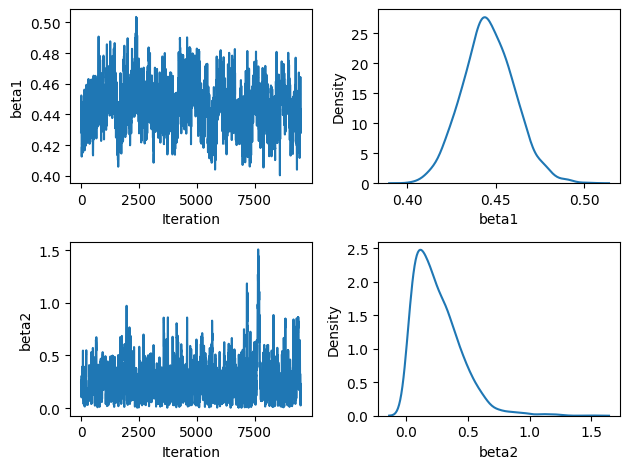

In [46]:
fig, ax = plt.subplots(2, 2)

def trace_and_density(samples, ax, name):
    ax[0].plot(samples)
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel(name)
    sns.kdeplot(samples, bw_adjust=1.5, ax=ax[1])
    ax[1].set_xlabel(name)

trace_and_density(samples.beta1[500:], ax=ax[0], name="beta1")
trace_and_density(samples.beta2[500:], ax=ax[1], name="beta2")
fig.tight_layout()

__N.B.__ The MCMC mixing for $\beta_1$ and $\beta_2$ will never be quite as good when the censored data is being estimated as compared to if it is assumed known.  This is because an _a priori_ strong correlation exists between the infection rate and the timing of the $S \rightarrow I$ events.  This is inherent to the model, and is one of the reasons why epidemic inference is so hard: the current flurry of SMC, MCMC, and ABC research is trying to find ways to improve this situation!.

Let's look at the posterior over the number of initial infectives.  

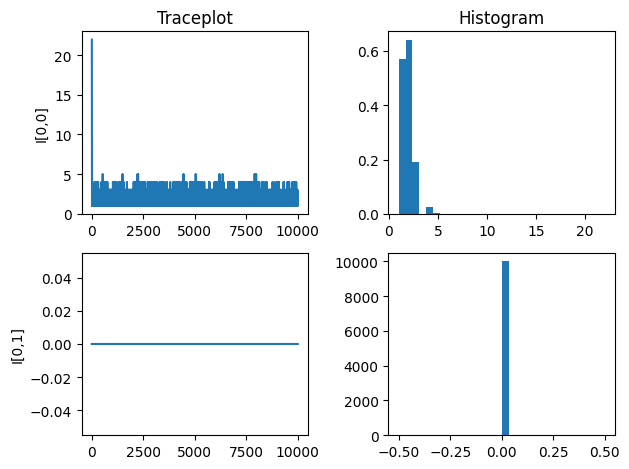

In [48]:
fig, ax = plt.subplots(2, 2)

# Population 0
ax[0][0].plot(samples.initial_conditions[:, 0, 1])
ax[0][1].hist(samples.initial_conditions[:, 0, 1], bins=30, density=True)
ax[0][0].set_title("Traceplot")
ax[0][1].set_title("Histogram")
ax[0][0].set_ylabel("I[0,0]")

# Population 1
ax[1][0].plot(samples.initial_conditions[:, 1, 1])
_ = ax[1][1].hist(samples.initial_conditions[:, 1, 1], bins=30)
ax[1][0].set_ylabel("I[0,1]")

fig.tight_layout()

These results seem to make sense -- we are capturing a low number of initial infections (1 or 2) in population 0, and have overwhelmingly strong evidence that population 1 was disease free at the beginning of the time period.